# Loading observational data into Bagpipes

This example will show you how to input your observational data ready for fitting. For further information see the [inputting observational data](http://bagpipes.readthedocs.io/en/latest/loading_galaxies.html) page of the documentation.

## The load data function

In order to load up data you need to write a function which accepts an ID (this should be a string) and returns your data in the format Bagpipes expects. 

For photometry this format is a nx2 array containing fluxes and flux errors in microjanskys. For spectroscopy this format is a nx3 array containing wavelengths in angstroms, fluxes and flux errors in ergs/s/cm^2/A.

Below is an example load data function for loading UltraVISTA photometry from the catalogue included in this directory:

In [1]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits
from glob import glob

def load_uvista(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue.
    hdulist = np.loadtxt("UltraVISTA_catalogue.cat",
                         usecols=(0,3,4,5,6,7,8,9,10,11,12,13,14,15,
                                  16,17,18,19,20,21,22,23,24,25,26))

    # Check the object is in the catalogue.
    if np.min(np.abs(hdulist[:,0] - int(ID))) != 0:
        sys.exit("Object not found in catalogue")

    tablerow = np.argmin(np.abs(hdulist[:,0] - int(ID)))

    # Extract the object we're interested in from the catalogue.
    phot_fluxes = hdulist[tablerow, 1:13]
    phot_fluxerrs = hdulist[tablerow, 13:25]

    phot = np.zeros(len(phot_fluxes)*2)
    phot.shape = (len(phot_fluxes), 2)
    
    # Convert to microjanskys
    phot[:,0] = phot_fluxes*10**29
    phot[:,1] = phot_fluxerrs*10**29

    # blow up the errors associated with any N/A points in the phot
    for i in range(len(phot)):
        if ((phot[i, 0] == 0. or phot[i, 1] <= 0) 
                or (phot[i, 1] > 0 and -phot[i, 0] >= 2*phot[i, 1])):
            phot[i,:] = [0., 9.9*10**99.]

    return phot

We can see that it returns the correct two-column format for the first object in the catalogue:

In [2]:
print load_uvista("96976")

[[2.227857e-01 1.280610e-02]
 [3.853693e-01 1.926846e-02]
 [1.223257e+00 6.116285e-02]
 [3.419206e+00 1.709603e-01]
 [6.419619e+00 3.209810e-01]
 [7.164044e+00 3.582022e-01]
 [9.255203e+00 4.627602e-01]
 [1.239207e+01 6.196035e-01]
 [1.606604e+01 8.033020e-01]
 [2.082824e+01 1.041412e+00]
 [2.570926e+01 2.570926e+00]
 [1.668961e+01 1.668961e+00]]


All that's needed now is to pass the ID and load_uvista function to the bagpipes galaxy class, along with the list of paths to filter curves in the same order as the fluxes are returned by load_uvista.

As we're not inputting any spectroscopic data we'll also need to set the keyword argument spectrum_exists to False:

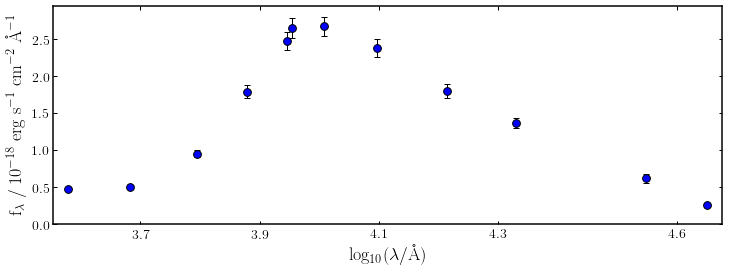

In [3]:
uvista_filt_list = ["uvista/CFHT_u.txt",
                    "uvista/CFHT_g.txt",
                    "uvista/CFHT_r.txt",
                    "uvista/CFHT_i+i2.txt",
                    "uvista/CFHT_z.txt",
                    "uvista/subaru_z",
                    "uvista/VISTA_Y.txt",
                    "uvista/VISTA_J.txt",
                    "uvista/VISTA_H.txt",
                    "uvista/VISTA_Ks.txt",
                    "uvista/IRAC1",
                    "uvista/IRAC2"]

galaxy = pipes.galaxy("96976", load_uvista, spectrum_exists=False, 
                      filt_list=uvista_filt_list)
fig = galaxy.plot()

## Adding spectroscopic data

The data load function can return photometry, spectroscopy or both. Let's try an example with spectroscopy. Fortuitously, the first object in the catalogue has also been observed by the Lega-C survey. The fits file in this directory comes from their first public data release. We can load it into Bagpipes with the following function:

In [4]:
def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum)/binn
    binspec = np.zeros((nbins, spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec


def load_legac_spec(ID):
    """ Load legac spectroscopic data from file. """

    hdulist = fits.open(ID + ".fits")

    spectrum = np.zeros((hdulist[1].data["WAVE"].shape[1], 3))

    spectrum[:,0] = hdulist[1].data["WAVE"][0,:]
    spectrum[:,1] = hdulist[1].data["FLUX"][0,:]
    spectrum[:,2] = hdulist[1].data["ERR"][0,:]

    mask = hdulist[1].data["QUAL"][0,:]==1

    spectrum[:,1] *= 10**-19
    spectrum[:,2] *= 10**-19

    spectrum[mask, 2] = 10**10

    spectrum = spectrum[(spectrum[:,0] > 6300.) & (spectrum[:,0] < 8800.),:]

    return bin(spectrum, 4)

This time there's no need to pass the filt_list argument, and it's the photometry_exists keyword argument we need to set to False:

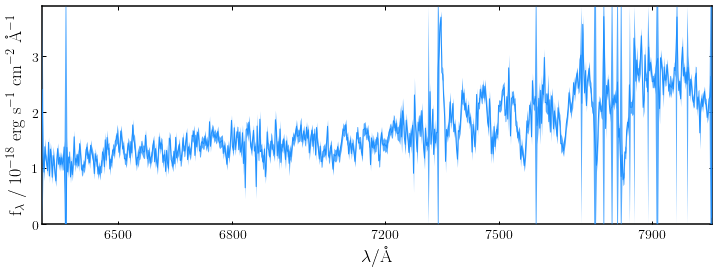

In [5]:
galaxy = pipes.galaxy("96976", load_legac_spec, photometry_exists=False)

fig = galaxy.plot()

## Loading photometry and spectroscopy

Now let's put it all together. We can define a function which calls both load_uvista and load_legac_spec and returns the spectrum and photometry. When we're loading both kinds of data, bagpipes expects the spectrum first and then the photometry, like so:

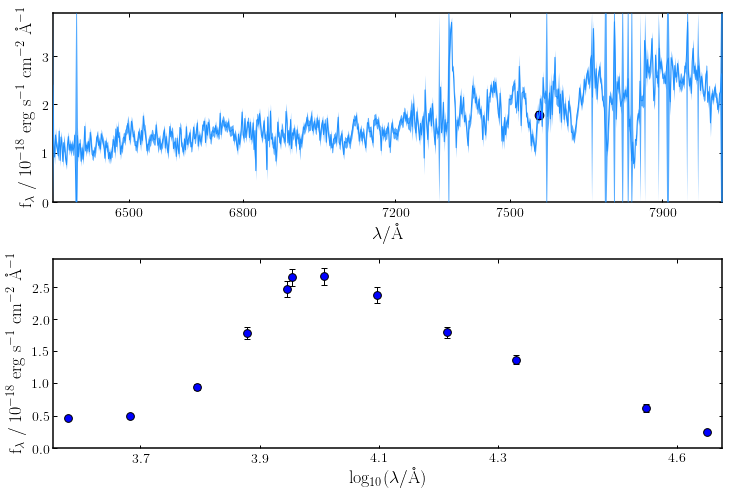

In [6]:
def load_both(ID):
    spectrum = load_legac_spec(ID)
    phot = load_uvista(ID)

    return spectrum, phot

galaxy = pipes.galaxy("96976", load_both, filt_list=uvista_filt_list)

fig = galaxy.plot()

That's about all there is to know, you can see that photometric points which fall within the wavelength range of the spectrum are plotted on the upper panel so you can see how well the calibration of the spectrum and photometry agrees.